## IMPORT LIBRARIES AND DATASET

In [1]:
import pandas as pd
import numpy as np 

from matplotlib import pyplot as plt 
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import accuracy_score, roc_curve, auc

import shap
from IPython.display import HTML

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Import dataset after EDA (without normalization)
#df = pd.read_csv('dataset_after_eda/Dataset_after_eda.csv', sep=',')

# Import Normalized dataset after EDA
df = pd.read_csv('dataset_after_eda/Normalized_dataset_after_eda.csv', sep=',')


In [3]:
# Target is 'stroke' which has two values 0 and 1

X = df.drop('stroke', axis=1)
y = df['stroke']

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=59)
X_smote, y_smote = smote.fit_resample(X, y)

## Shapley values in 10 folds Cross-Validation without iteration

In [4]:
# Perform iterated 10-fold stratified cross-validation for each model (WITHOUT ITERATIONS)

# DF to save results
results_test_iter = pd.DataFrame()
results_test = pd.DataFrame()

# DF to store confusion matrix and ROC results
test_confusion = pd.DataFrame()
roc = pd.DataFrame()

# Number of iterations
num_iter = 1

# Define dict for each metric for both test predictions
test_metrics = {
    'Accuracy' : [],
    'Precision' : [],
    'Recall' : [],
    'F1 Score' : [],
    'AUC' : []
}

# List to store importance values to plot a feature importance
feature_importances = []

# Lists to store shapley values and baseline values for each class: stroke = [0,1]
shap_values_for_folds_0 = []
baseline_values_for_folds_0 = []
shap_values_for_folds_1 = []
baseline_values_for_folds_1 = []

# Define model
model = RandomForestClassifier(random_state=59)
name = "Random Forest"

# List to save the order of test samples in each CV fold
ix_test = []

for i in range(0,num_iter):

    # Set up stratified CV
    stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state= i)
    
    for j, (train_index, test_index) in enumerate(stratified_cv.split(X_smote, y_smote)):

        print(f'Split {j+1}...')

        ix_test.append(test_index)

        X_train_fold, X_test_fold = X_smote.iloc[train_index], X_smote.iloc[test_index]
        y_train_fold, y_test_fold = y_smote.iloc[train_index], y_smote.iloc[test_index]

        model.fit(X_train_fold, y_train_fold)

        # predictions
        y_pred_fold = model.predict(X_test_fold)

        # Define explainer for SHAP
        explainer = shap.Explainer(model)

        # Shapley values and baselines for X_test_fold
        shap_values = explainer(X_test_fold).values
        baselines = explainer(X_test_fold).base_values
        
        # Store Shapley values and baselines for each CV fold
        shap_values_for_folds_0.append(shap_values[:,:,0])
        shap_values_for_folds_1.append(shap_values[:,:,1])
        baseline_values_for_folds_0.append(baselines[:,0])
        baseline_values_for_folds_1.append(baselines[:,1])
        
        # metrics calculation for test
        test_metrics['Accuracy'].append(accuracy_score(y_test_fold, y_pred_fold))
        test_metrics['Precision'].append(precision_score(y_test_fold, y_pred_fold))
        test_metrics['Recall'].append(recall_score(y_test_fold, y_pred_fold))
        test_metrics['F1 Score'].append(f1_score(y_test_fold, y_pred_fold))
        test_metrics['AUC'].append(roc_auc_score(y_test_fold, y_pred_fold))
        
        # Append feature importances
        feature_importances.append(model.feature_importances_)

# Collecting metric values for eahc iteration for each model (both train and test)
metric_test_iter = {
    metric : value for metric, value in test_metrics.items()
}
cols_iter = pd.MultiIndex.from_product([[name], [str(j) for j in range(0,num_iter*10)]])
results_test_iter_medium = pd.DataFrame(metric_test_iter.values(), columns=cols_iter)
results_test_iter = pd.concat([results_test_iter, results_test_iter_medium], axis=1)


# Collecting mean and std values for each metric and for each model (both train and test)
mean_folds_metrics = {
    metric : (np.mean(value), np.std(value)) for metric, value in test_metrics.items()
}
cols = pd.MultiIndex.from_product([[name], ['Mean', 'Std']])
res_test_medium = pd.DataFrame(mean_folds_metrics.values(), columns=cols)
results_test = pd.concat([results_test, res_test_medium], axis=1)

# Use metrics names as rows index
results_test.index = mean_folds_metrics.keys()
results_test_iter.index = metric_test_iter.keys()

# Create a list for the index of the test subjects
list_index_test = [element for array in ix_test for element in array]

# Create an array for the Shapley values for each test subject
array_shap_1 = np.array([element for shapley in shap_values_for_folds_1 for element in shapley])
array_shap_0 = np.array([element for shapley in shap_values_for_folds_0 for element in shapley])

# Create an array for the base values for each test subject
array_baseline_1 = np.array([element for shapley in baseline_values_for_folds_1 for element in shapley])
array_baseline_0 = np.array([element for shapley in baseline_values_for_folds_0 for element in shapley])

Split 1...
Split 2...
Split 3...
Split 4...
Split 5...
Split 6...
Split 7...
Split 8...
Split 9...
Split 10...


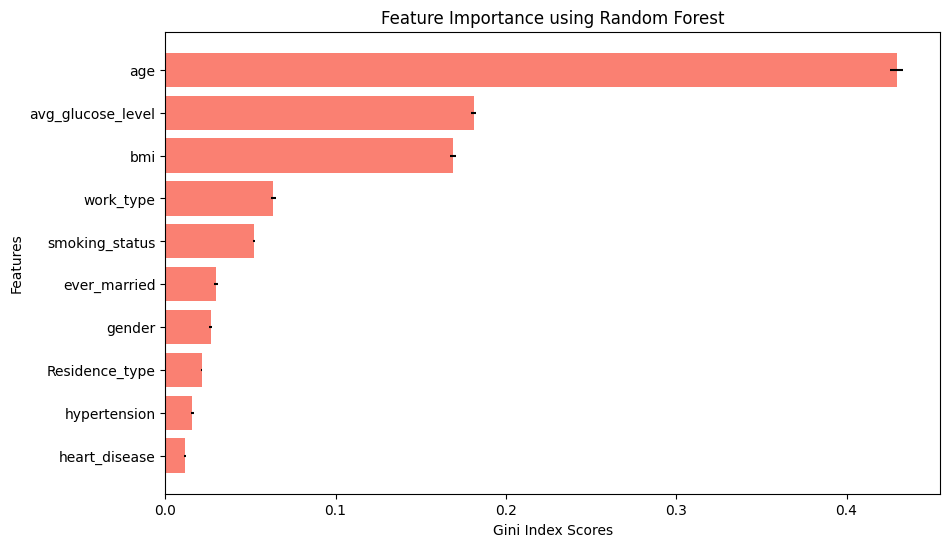

In [5]:
# FEATURE IMPORTANCE 

# Compute mean importance across folds
mean_importances = np.mean(feature_importances, axis=0)
std_importances = np.std(feature_importances, axis=0)

# Sort features by mean importance
sorted_indices = np.argsort(mean_importances)

# Plot feature importances

plt.figure(figsize=(10, 6))

plt.barh(range(len(sorted_indices)), mean_importances[sorted_indices], xerr=std_importances[sorted_indices] , color='salmon')

plt.yticks(range(len(sorted_indices)), [X_smote.columns[i] for i in sorted_indices])
plt.xlabel("Gini Index Scores")
plt.ylabel("Features")
plt.title("Feature Importance using Random Forest")
plt.show()

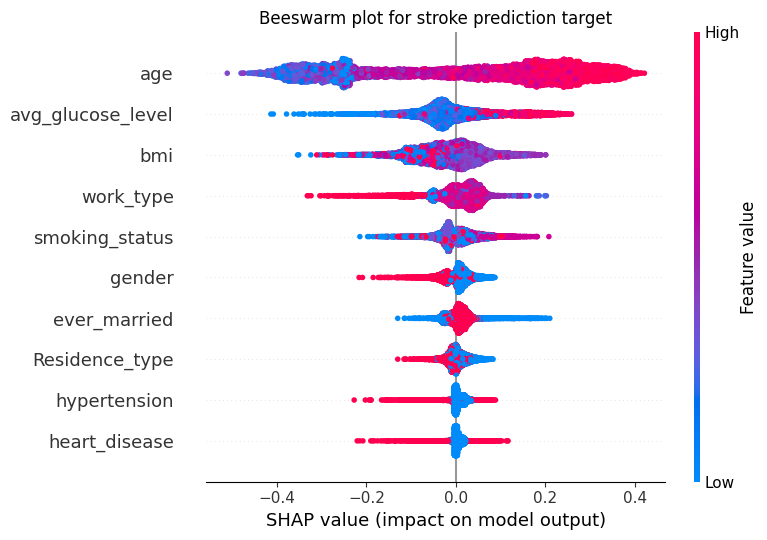

In [6]:
# GLOBAL EXPLANATION using SHAPLEY VALUES

plt.title('Beeswarm plot for stroke prediction target')

shap.summary_plot(array_shap_1, X_smote.reindex(list_index_test))

In [ ]:
# JUST A REMINDER

""" {'gender': {'Female': 0, 'Male': 1},
 'work_type_mapping': {'Govt_job': 4, 'Never_worked': 1, 'Private': 3, 'Self-employed': 2, 'children': 0},
 'smoking_status': {'Unknown': 1, 'formerly smoked': 2, 'never smoked': 0, 'smokes': 3},
 'ever_married': {'No': 0, 'Yes': 1},
 'Residence_type': {'Rural': 0, 'Urban': 1}} """

In [ ]:
# CONCLUSION AFTER SUMMARY PLOT

# As you can see, the feature importance obtained with Shapley values is almost the same we have obtained with Gini index. 
# Here we can see the incredible power from explainability, we don't have just a list of important features, we can see how those
# values are distributed and which impact the model output the most.

# As expected, age is the most important feature with the higher values that impact the decision-making of the model 
# towards the stroke prediction

# For high average glucose level the model tends to predict the patients with stroke and it has a greater impact respect to 
# the lower values

# bmi has a strange behaviour because the feature value distribution is not so clear, even though it appears that higher values tend 
# the most to impact the stroke prediction

# work_type: higher values correspond to people with full-time jobs and it seems they don't have a great impact with stroke prediction
# differently from other categories

# smoking_status: higher values correspond to people who smoke and it has a distribution as expected 

# gender: lower values correspond to Famale people and it seems they have a greater impact to stroke prediction 

# residence_type: higher values correspond to Urban and it seems they have a lower impact to stroke prediction

# ever_married: higher values correspond to Yes which has no impact to stroke prediction respect to No option

# hypertension and heart_disease don't show a net distribution with the stroke prediction. Low values (both are equals to patients 
# without these diseases) have no impact on model output to predict stroke and high values (people with these diseases) have omogeneus 
# distribution on the impact (some of them tends to predict stroke and others tends the model towards no stroke prediction).

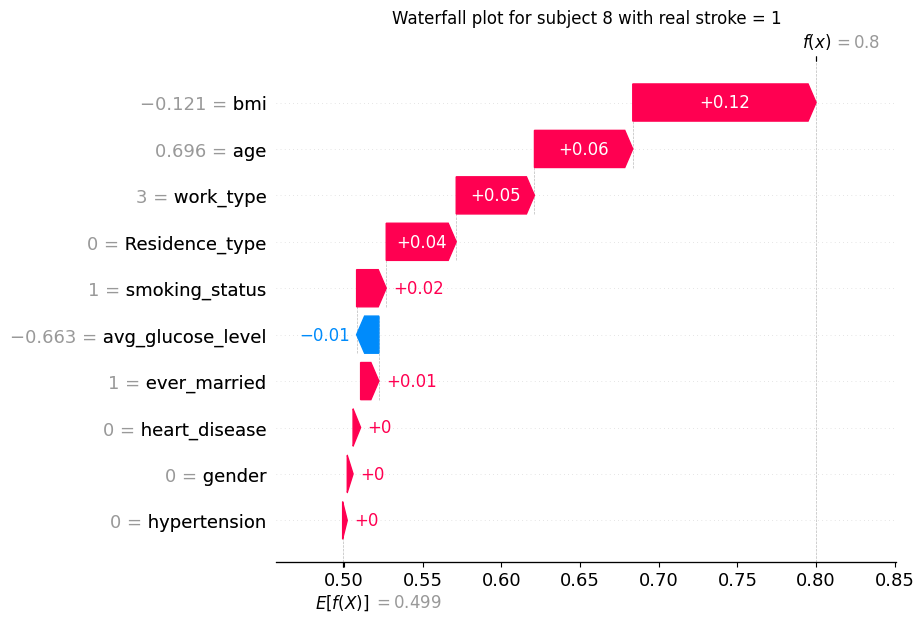

In [70]:
# LOCAL EXPLANATIONS using SHAPLEY VALUES
# Waterfall Plot

subject = 8

new_index = list_index_test.index(subject)


plt.title(f'Waterfall plot for subject {subject} with real stroke = {y_smote[subject]}')

shap.waterfall_plot(shap.Explanation(values = array_shap_1[new_index], 
                                        base_values = array_baseline_1[new_index], 
                                        data = X_smote.reindex(list_index_test).iloc[new_index],  
                                        feature_names = X_smote.columns.tolist())
                    )


In [ ]:
# CONCLUSION AFTER WATERFALL PLOT

# As you can see the enormous advantage to use the Shapley values is to get a local explanation for each subject about the feature
# importance; which features impact the most to predict correctly the istance in order to increase the eXplainability for a ML model.

# For the subject 8, age is at the 2-nd importance place to predict correctly its stroke value, differently form the global importance 
# in which age always appears at the 1-st place. In this way, we can understand how ML model behaves differently acccording to the 
# subject it analyzes.

## Shapley values with Iterated 10-folds CV

In [71]:
# Perform iterated 10-fold stratified cross-validation for each model (WITH ITERATIONS)
# This will allow me to obtain more stable results, even though they could not change respect the previous ones.

# DF to save results
results_test_iter = pd.DataFrame()
results_test = pd.DataFrame()

# DF to store confusion matrix and ROC results
test_confusion = pd.DataFrame()
roc = pd.DataFrame()

# Number of iterations
num_iter = 5

# Define dict for each metric for both test predictions
test_metrics = {
    'Accuracy' : [],
    'Precision' : [],
    'Recall' : [],
    'F1 Score' : [],
    'AUC' : []
}

# Define dict for shapley values and baselines for each class
shap_values_1_per_cv = dict()
shap_values_0_per_cv = dict()
baselines_1_per_cv = dict()
baselines_0_per_cv = dict()

for subject in X_smote.index:
    # Create keys for each subject
    shap_values_1_per_cv[subject] = {} 
    shap_values_0_per_cv[subject] = {} 
    baselines_1_per_cv[subject] = {} 
    baselines_0_per_cv[subject] = {} 
    # Create keys for each CV fold within each subject
    for cv_iteration in range(num_iter):
        shap_values_1_per_cv[subject][cv_iteration] = {}
        shap_values_0_per_cv[subject][cv_iteration] = {}
        baselines_1_per_cv[subject][cv_iteration] = {}
        baselines_0_per_cv[subject][cv_iteration] = {}

# Define model
model = RandomForestClassifier(random_state=59)
name = "Random Forest"

for i in range(0,num_iter):

    print(f'Iteration {i+1}...')

    # Set up stratified CV
    stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state= i)
    
    for j, (train_index, test_index) in enumerate(stratified_cv.split(X_smote, y_smote)):

        print(f'Split {j+1}...')

        X_train_fold, X_test_fold = X_smote.iloc[train_index], X_smote.iloc[test_index]
        y_train_fold, y_test_fold = y_smote.iloc[train_index], y_smote.iloc[test_index]

        model.fit(X_train_fold, y_train_fold)

        # predictions
        y_pred_fold = model.predict(X_test_fold)

        # Define explainer for SHAP
        explainer = shap.Explainer(model)

        # shapley values and baseline values for X_test_fold
        shap_values = explainer(X_test_fold).values
        baselines = explainer(X_test_fold).base_values

        # Insert shapley values and baseline values for each subject in X_test_fold for each stroke class [0,1]
        for k, test_idx in enumerate(test_index):
            shap_values_1_per_cv[test_idx][i] = shap_values[:,:,1][k]
            shap_values_0_per_cv[test_idx][i] = shap_values[:,:,0][k]
            baselines_1_per_cv[test_idx][i] = baselines[:,1][k]
            baselines_0_per_cv[test_idx][i] = baselines[:,0][k]
        
        # metrics calculation for test
        test_metrics['Accuracy'].append(accuracy_score(y_test_fold, y_pred_fold))
        test_metrics['Precision'].append(precision_score(y_test_fold, y_pred_fold))
        test_metrics['Recall'].append(recall_score(y_test_fold, y_pred_fold))
        test_metrics['F1 Score'].append(f1_score(y_test_fold, y_pred_fold))
        test_metrics['AUC'].append(roc_auc_score(y_test_fold, y_pred_fold))

# Collecting metric values for eahc iteration for each model (both train and test)
metric_test_iter = {
    metric : value for metric, value in test_metrics.items()
}
cols_iter = pd.MultiIndex.from_product([[name], [str(j) for j in range(0,num_iter*10)]])
results_test_iter_medium = pd.DataFrame(metric_test_iter.values(), columns=cols_iter)
results_test_iter = pd.concat([results_test_iter, results_test_iter_medium], axis=1)


# Collecting mean and std values for each metric and for each model (both train and test)
mean_folds_metrics = {
    metric : (np.mean(value), np.std(value)) for metric, value in test_metrics.items()
}
cols = pd.MultiIndex.from_product([[name], ['Mean', 'Std']])
res_test_medium = pd.DataFrame(mean_folds_metrics.values(), columns=cols)
results_test = pd.concat([results_test, res_test_medium], axis=1)

# Use metrics names as rows index
results_test.index = mean_folds_metrics.keys()
results_test_iter.index = metric_test_iter.keys()

Iteration 1...
Split 1...
Split 2...
Split 3...
Split 4...
Split 5...
Split 6...
Split 7...
Split 8...
Split 9...
Split 10...
Iteration 2...
Split 1...
Split 2...
Split 3...
Split 4...
Split 5...
Split 6...
Split 7...
Split 8...
Split 9...
Split 10...
Iteration 3...
Split 1...
Split 2...
Split 3...
Split 4...
Split 5...
Split 6...
Split 7...
Split 8...
Split 9...
Split 10...
Iteration 4...
Split 1...
Split 2...
Split 3...
Split 4...
Split 5...
Split 6...
Split 7...
Split 8...
Split 9...
Split 10...
Iteration 5...
Split 1...
Split 2...
Split 3...
Split 4...
Split 5...
Split 6...
Split 7...
Split 8...
Split 9...
Split 10...


In [72]:
# AVERAGE SHAPLEY VALUES FOR EACH ITERATION

# Establish lists to keep average Shap values, their Stds, and their min and max (optionals) for each stroke class [0,1]
average_shap_values_1, stds_s_1, ranges_s_1 = [],[],[]
average_shap_values_0, stds_s_0, ranges_s_0 = [],[],[]
average_baselines_1, stds_b_1, ranges_b_1 = [],[],[]
average_baselines_0, stds_b_0, ranges_b_0 = [],[],[]

for i in range(0,len(X_smote)):
    # Get relevant statistics for every sample 
    # Shapley values class 1
    average_shap_values_1.append(pd.DataFrame.from_dict(shap_values_1_per_cv[i]).mean(axis=1).values) 
    stds_s_1.append(pd.DataFrame.from_dict(shap_values_1_per_cv[i]).std(axis=1).values)
    ranges_s_1.append(pd.DataFrame.from_dict(shap_values_1_per_cv[i]).max(axis=1).values-pd.DataFrame.from_dict(shap_values_1_per_cv[i]).min(axis=1).values)
    
    # Shapley values class 0
    average_shap_values_0.append(pd.DataFrame.from_dict(shap_values_0_per_cv[i]).mean(axis=1).values) 
    stds_s_0.append(pd.DataFrame.from_dict(shap_values_0_per_cv[i]).std(axis=1).values)
    ranges_s_0.append(pd.DataFrame.from_dict(shap_values_0_per_cv[i]).max(axis=1).values-pd.DataFrame.from_dict(shap_values_0_per_cv[i]).min(axis=1).values)
    
    # baselines class 1
    average_baselines_1.append(pd.DataFrame.from_dict(baselines_1_per_cv[i].values()).mean(axis=0).values) 
    stds_b_1.append(pd.DataFrame.from_dict(baselines_1_per_cv[i].values()).std(axis=0).values)
    ranges_b_1.append(pd.DataFrame.from_dict(baselines_1_per_cv[i].values()).max(axis=0).values-pd.DataFrame.from_dict(baselines_1_per_cv[i].values()).min(axis=0).values)
    
    # baselines class 0
    average_baselines_0.append(pd.DataFrame.from_dict(baselines_0_per_cv[i].values()).mean(axis=0).values) 
    stds_b_0.append(pd.DataFrame.from_dict(baselines_0_per_cv[i].values()).std(axis=0).values)
    ranges_b_0.append(pd.DataFrame.from_dict(baselines_0_per_cv[i].values()).max(axis=0).values-pd.DataFrame.from_dict(baselines_0_per_cv[i].values()).min(axis=0).values)

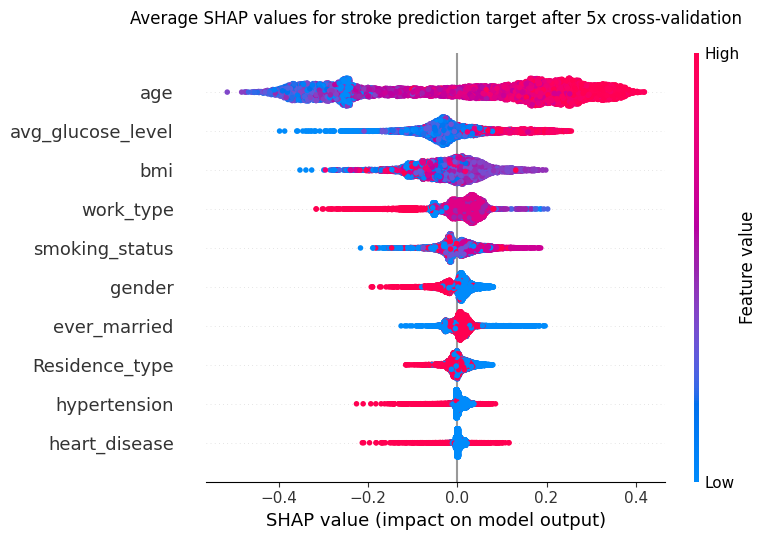

In [73]:
# GLOBAL INFORMATION 
# As you can see the order of feature importance is not changed, but now the results are more robust

plt.title('Average SHAP values for stroke prediction target after 5x cross-validation\n')

shap.summary_plot(np.array(average_shap_values_1), X_smote, show = False)

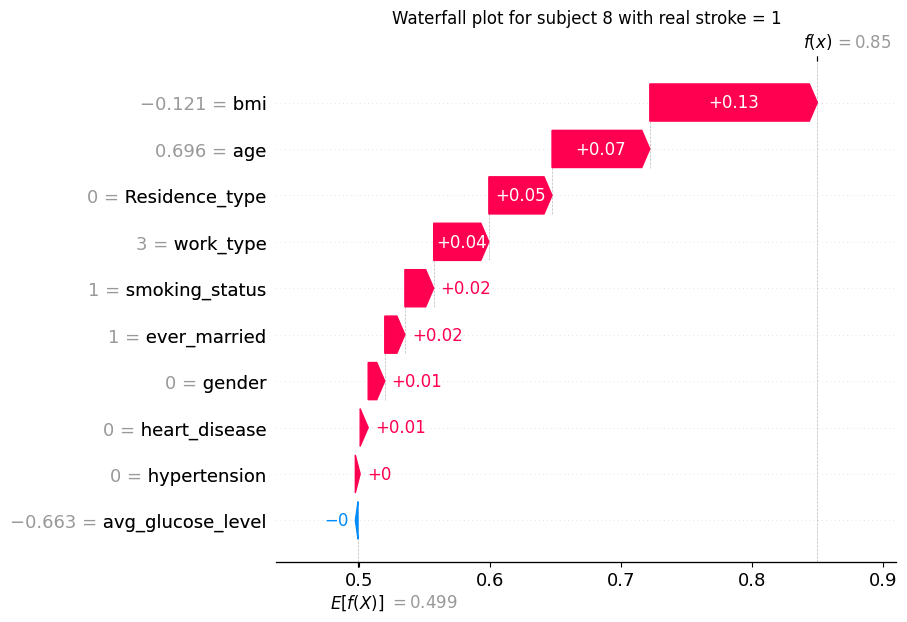

In [74]:
# LOCAL EXPLANATIONS
# Waterfall Plot

# Here you can see some differences, average glucose level is a the bottom of this calssify and some features have slightly changed
# their positions respect to the previous we got with waterfall plot without iterated CV

subject = 8


plt.title(f'Waterfall plot for subject {subject} with real stroke = {y_smote[subject]}')

shap.waterfall_plot(shap.Explanation(values = average_shap_values_1[subject], 
                                        base_values = average_baselines_1[subject], 
                                        data = X_smote.iloc[subject],  
                                        feature_names = X_smote.columns.tolist())
                    )

## APPENDIX

In [305]:
# THIS SUBSECTION TO SHOW OTHER POSSIBLE PLOT IT IS POSSIBLE TO OBTAIN USING SHAPLEY VALUES

# Recreate an EXPLAINER using average Shapley and baseline values for class stroke = 1

explainar_post = shap.Explanation(values = np.array(average_shap_values_1), 
                                        base_values = np.array(average_baselines_1), 
                                        data = np.array(X_smote),  
                                        feature_names = np.array(X_smote.columns.tolist()))

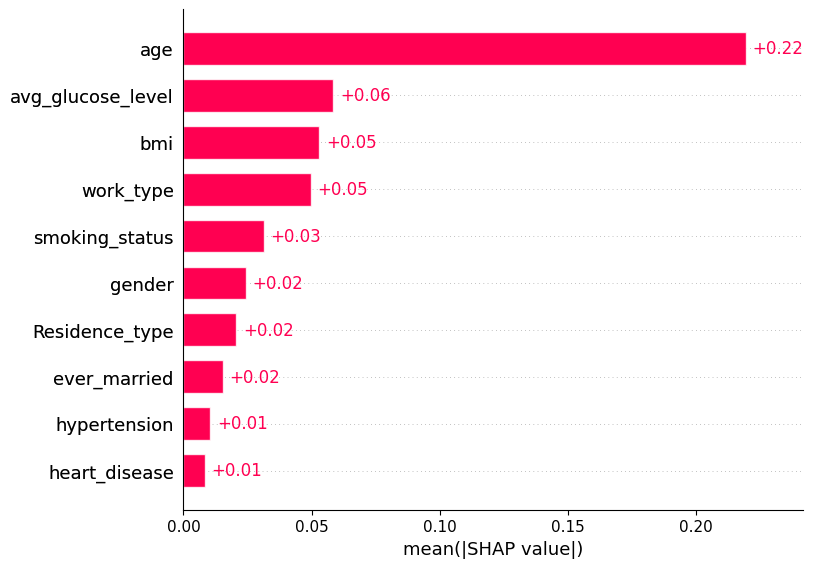

In [292]:
# Bar plot using Shaply values

shap.plots.bar(explainar_post)

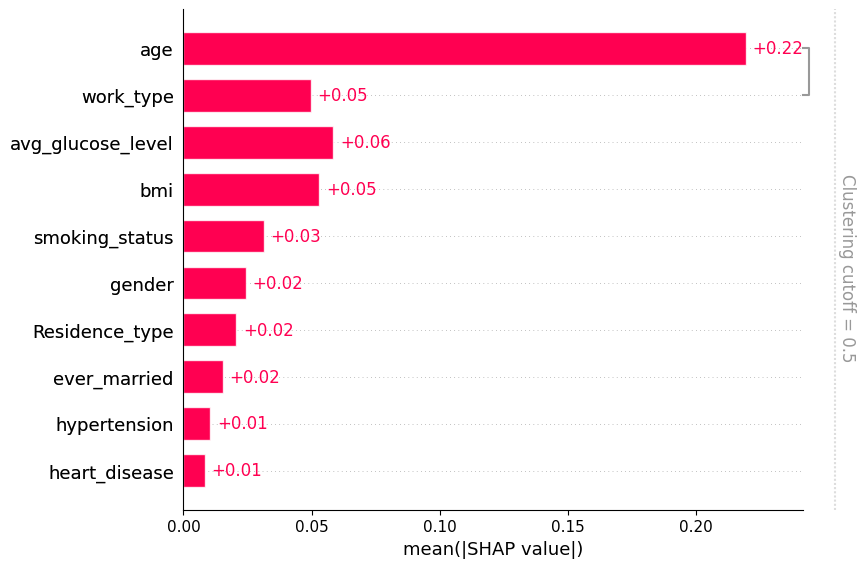

In [364]:
# CLUSTERING using SHAPLEY VALUES
# Shap feature clustering highlights highly correlated variables. 

# You can see that age and work_type seem to be highly correlated but using a cut-off e quals to 0.5

shap_clustering = shap.utils.hclust(X_smote, y_smote)
shap.plots.bar(explainar_post, clustering=shap_clustering, clustering_cutoff=0.5)

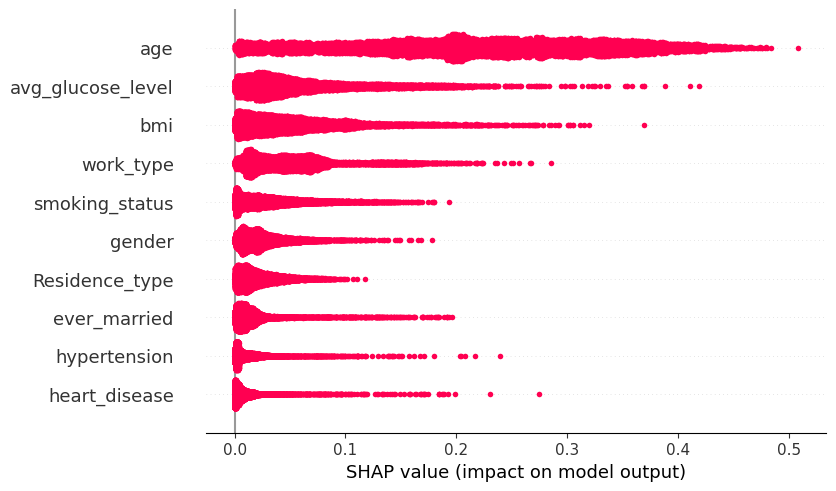

In [293]:
# Beeswarm plot as bar plot using abs Shapley values

shap.plots.beeswarm(explainar_post.abs, color="shap_red")

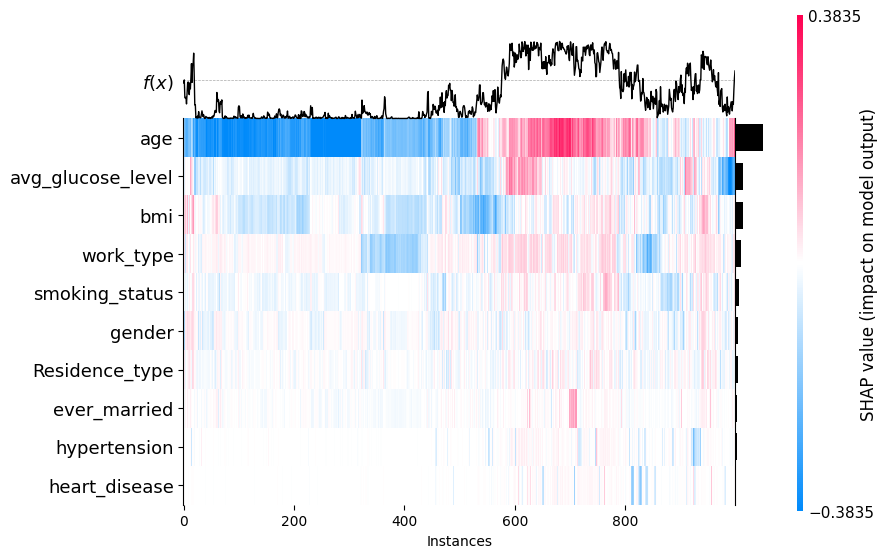

In [294]:
# Heatmap of Shapley values for the first 1000 istances 

shap.plots.heatmap(explainar_post[:1000])

In [328]:
# In order to visualize a scatter plot, I create a new explanation object without base values (we don't need them)

explainar_post_2 = shap.Explanation(values = np.array(average_shap_values_1), 
                                        data = np.array(X_smote),  
                                        feature_names = np.array(X_smote.columns.tolist()))

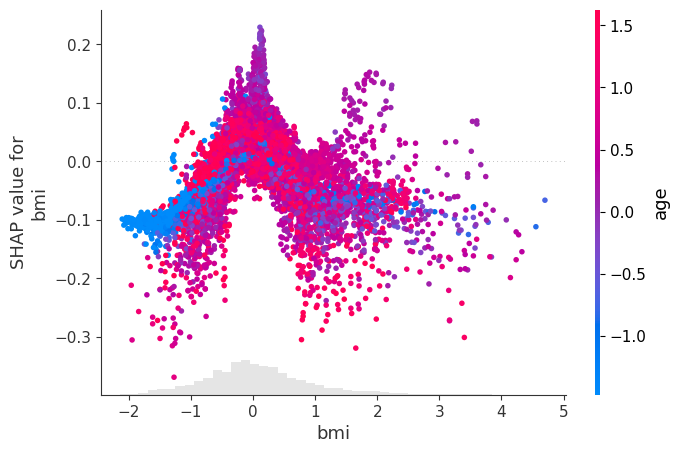

In [374]:
# Scatter Plot

shap.plots.scatter(explainar_post_2[:,'bmi'], color = explainar_post_2)

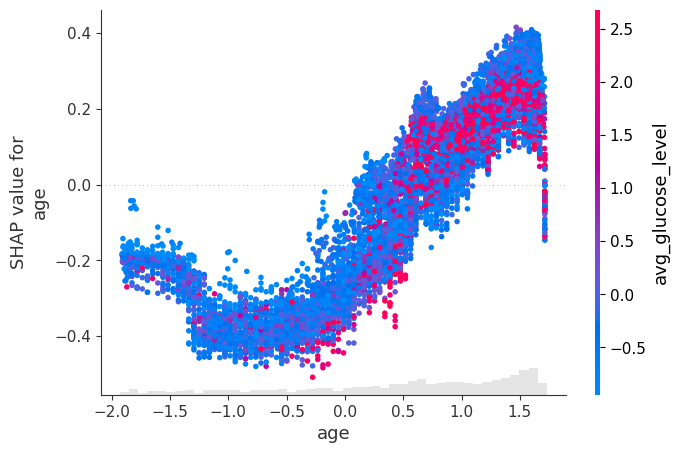

In [375]:
# Scatter Plot

shap.plots.scatter(explainar_post_2[:,'age'], color = explainar_post_2)

In [379]:
# Force Plot for one observation

shap.initjs()

force_plot = shap.plots.force(explainar_post[8])

# To get a white background with dark-mode
HTML(f"<div style='background-color:white;'>{shap.getjs() + force_plot.html()}</div>")